# Data Analysis Interview Challenge

## Part 1 - Exploratory Data Analysis
The logins.json file contains (simulated) timestamps of user logins in a particular geographic location. 

The analysis:  
1) Aggregate these login counts based on 15­minute time intervals, and visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand.  

2) Report/illustrate important features of the demand, such as daily cycles. 

3) Identify any data quality issues

## 1. Sourcing and Loading

### 1a. Load relevant libraries 

In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter 
import seaborn as sns
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
# Set the style to "darkgrid"
sns.set_style('darkgrid')
sns.set_palette(["#39A7D0","#36ADA4"])

### 1b. Load the data
Call the variable `logins`. 

In [2]:
# Read in file
logins = pd.read_json("data/logins.json")
print(logins.shape)
print(logins.info)
print(logins.columns)
logins.head()

(93142, 1)
<bound method DataFrame.info of                login_time
0     1970-01-01 20:13:18
1     1970-01-01 20:16:10
2     1970-01-01 20:16:37
3     1970-01-01 20:16:36
4     1970-01-01 20:26:21
...                   ...
93137 1970-04-13 18:50:19
93138 1970-04-13 18:43:56
93139 1970-04-13 18:54:02
93140 1970-04-13 18:57:38
93141 1970-04-13 18:54:23

[93142 rows x 1 columns]>
Index(['login_time'], dtype='object')


,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


### 1c. Explore the data
We now need to check whether the data conduces to a time series style analysis.

In [3]:
# make sure datatime value and set the index
logins['login_time'] = pd.to_datetime(logins['login_time'])

logins = logins.set_index('login_time')

#pd.to_datetime(logins.index, unit='ns')
logins.head()

""
login_time
1970-01-01 20:13:18
1970-01-01 20:16:10
1970-01-01 20:16:37
1970-01-01 20:16:36
1970-01-01 20:26:21


In [4]:
# Look at duration of data
print("Start of data",min(logins.index))
print("End of data",max(logins.index))
print('Duration of data: ',logins.index.max()-logins.index.min(),'\n')

Start of data 1970-01-01 20:12:16
End of data 1970-04-13 18:57:38
Duration of data:  101 days 22:45:22 



In [5]:
# aggregate data and place counts of stamps between each 15 minutes in count column
# add column to aggregate
logins['count']=1
logins_every_15 = logins.resample("60T").agg({'count':'sum'})
logins_every_15['day'] = pd.DatetimeIndex(logins_every_15.index).day
logins_every_15['dayofweek'] = pd.DatetimeIndex(logins_every_15.index).dayofweek
logins_every_15['month'] = pd.DatetimeIndex(logins_every_15.index).month
logins_every_15['week'] = pd.DatetimeIndex(logins_every_15.index).week
logins_every_15['hour'] = pd.DatetimeIndex(logins_every_15.index).hour
logins_every_15.head()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  


,count,day,dayofweek,month,week,hour
login_time,,,,,,
1970-01-01 20:00:00,24,1,3,1,1,20
1970-01-01 21:00:00,9,1,3,1,1,21
1970-01-01 22:00:00,21,1,3,1,1,22
1970-01-01 23:00:00,58,1,3,1,1,23
1970-01-02 00:00:00,53,2,4,1,1,0


The 'logins_every_15' dataframe has the count of how many logins every 15 minutes with the additional features of day number of the month (from 1 to 31), the week number is the number of week within the year for the data collected (1 to 52 possible) and month number of the year for the months the data was collected

In [6]:
logins_every_15['day'].describe()

count    2447.000000
mean       14.569268
std         8.684673
min         1.000000
25%         7.000000
50%        14.000000
75%        22.000000
max        31.000000
Name: day, dtype: float64

In [7]:
logins_every_15['week'].describe()

count    2447.000000
mean        8.325296
std         4.216594
min         1.000000
25%         5.000000
50%         8.000000
75%        12.000000
max        16.000000
Name: week, dtype: float64

In [8]:
logins_every_15['hour'].describe()

count    2447.000000
mean       11.496935
std         6.923355
min         0.000000
25%         5.500000
50%        11.000000
75%        17.000000
max        23.000000
Name: hour, dtype: float64

In [9]:
# we can see that the data was collected for the first 16 weeks of the year (1970)
# look for missing values
print("Nan Values: ",logins_every_15.isnull().sum())
no_logins = logins_every_15[logins_every_15['count']==0]
print(no_logins.shape)
no_logins.head()


Nan Values:  count        0
day          0
dayofweek    0
month        0
week         0
hour         0
dtype: int64
(2, 6)


,count,day,dayofweek,month,week,hour
login_time,,,,,,
1970-01-08 15:00:00,0,8,3,1,2,15
1970-02-19 08:00:00,0,19,3,2,8,8


The data for this dataset is over a period of time 
from 8PM on Jan 1, 1970 to 6:45PM on Apr 13, 1970.  

The data 

In [10]:
# Look at data, count the number of each sum
logins_every_15['count'].value_counts()
# Look for and count the number of zero values across the count data
print("Zeros: ",(logins_every_15['count']==0).sum())

Zeros:  2


## 1d. Cleaning, transforming and visualizing

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  """


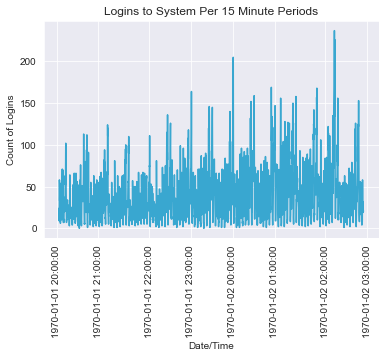

In [11]:
# plot the new time series data of logins per 15 minutes
fig, ax = plt.subplots()
ax.plot(logins_every_15['count'])
ax.set_xlabel('Date/Time')
ax.set_xticklabels(logins_every_15.index, rotation=90)
ax.set_ylabel('Count of Logins')
ax.set_title('Logins to System Per 15 Minute Periods')
plt.show()

Too much data for plot, so group by day and aggregate
Note that first and last days are partials, 
so remove first and last elements of DataFrame to account

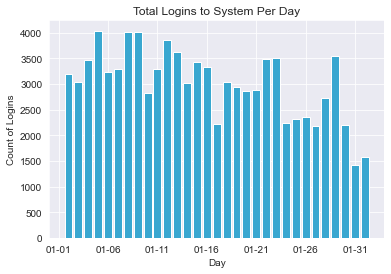

In [12]:
# group the data by day?
day_logins = logins_every_15.groupby(logins_every_15['day'])['count'].sum()
# display the graph of dayly counts
# Configure the plot
fig, ax = plt.subplots()
# set labels to be Month-Day
date_form = DateFormatter("%m-%d")
ax.xaxis.set_major_formatter(date_form)

ax.bar(day_logins.index,day_logins)
ax.set_xlabel('Day')
ax.set_ylabel('Count of Logins')
ax.set_title('Total Logins to System Per Day')
plt.show()

initial shape of day data:  (103, 1)
corrected shape of day data:  (101, 1)


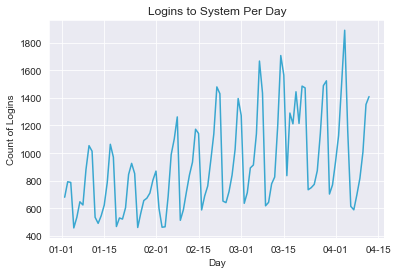

In [13]:
# group the data by day?
day_logins = logins.resample("D").agg({'count':'sum'})
print("initial shape of day data: ",day_logins.shape)
# remove first and last, since these are only partial days of data
day_logins = day_logins.iloc[1:-1,:]
print("corrected shape of day data: ",day_logins.shape)

# Configure the plot
fig, ax = plt.subplots()
# set labels to be Month-Day
date_form = DateFormatter("%m-%d")
ax.xaxis.set_major_formatter(date_form)

ax.plot(day_logins['count'])
ax.set_xlabel('Day')
ax.set_ylabel('Count of Logins')
ax.set_title('Logins to System Per Day')
plt.show()

With 9788 data points of count data (15 minute periods), the graph shows no day has zero total logins

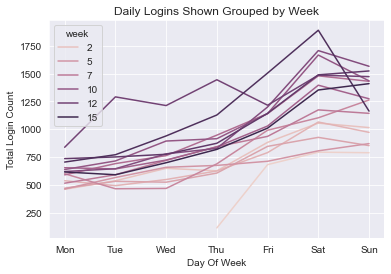

In [14]:
# Look at data by day grouped by week
days = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']
day_grp_logins = logins_every_15.reset_index().groupby(['dayofweek','week']).agg({'count':'sum'}).reset_index('week')
g = sns.lineplot(x=day_grp_logins.index,y=day_grp_logins['count'],hue=day_grp_logins['week'])
# Add a title 
g.set_title("Daily Logins Shown Grouped by Week")
g.set_xticks(range(7))
g.set_xticklabels(days)
# Add x-axis and y-axis labels
g.set(xlabel="Day Of Week",ylabel="Total Login Count")
plt.show()

In [15]:
# Look at data by day grouped by hour
hourly_logins = logins_every_15.reset_index().groupby(['hour','day']).agg({'count':'sum'}).reset_index('day')
hourly_logins.head(10)

,day,count
hour,,
0,1,178
0,2,224
0,3,139
0,4,311
0,5,214
0,6,170
0,7,242
0,8,228
0,9,191


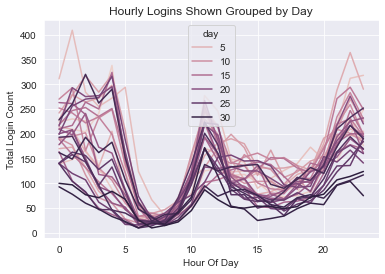

In [16]:
# Graph the hourly data
g = sns.lineplot(x=hourly_logins.index,y=hourly_logins['count'],hue=hourly_logins['day'])
# Add a title 
g.set_title("Hourly Logins Shown Grouped by Day")
# Add x-axis and y-axis labels
g.set(xlabel="Hour Of Day",ylabel="Total Login Count")
plt.show()

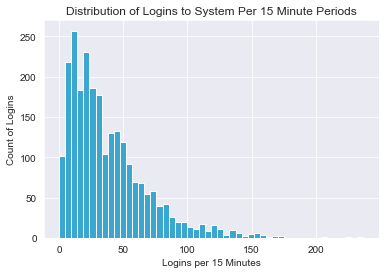

In [17]:
# Look at the distribution of data points for login counts
fig, ax = plt.subplots()
ax.hist(logins_every_15['count'], bins=50)
ax.set_xlabel('Logins per 15 Minutes')
#ax.set_xticklabels(logins2.index, rotation=90)
ax.set_ylabel('Count of Logins')
ax.set_title('Distribution of Logins to System Per 15 Minute Periods')
plt.show()

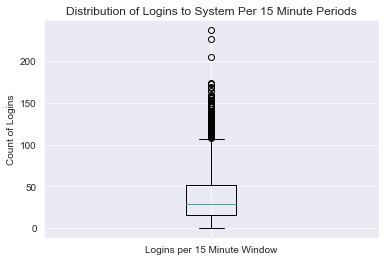

In [18]:
# Look at the boxplot of data points for login counts
fig, ax = plt.subplots()
ax.boxplot(logins_every_15['count'])
ax.set_xticklabels(['Logins per 15 Minute Window'])
ax.set_ylabel('Count of Logins')
ax.set_title('Distribution of Logins to System Per 15 Minute Periods')
plt.show()

From the views of the dataset, the data is clearly non-normal with wide standard deviation and a large number of zeros as well as data points above the limits of the box plot (Mean plus two and 1/2 standard deviations) 

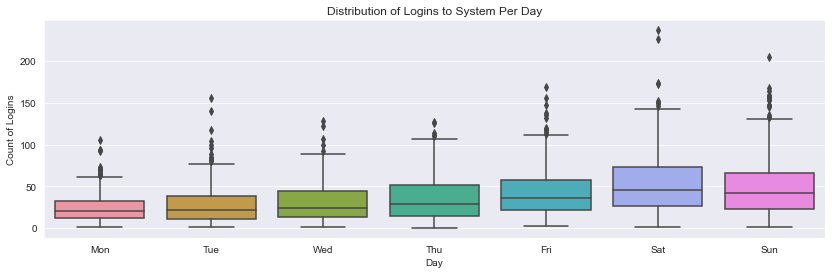

In [19]:
# Look at the boxplot of data points for login counts for each day of the week
fig = plt.figure(figsize=(14,4))
g = sns.boxplot(data=logins_every_15, x='dayofweek', y='count')
g.set_xticklabels(days)
g.set(xlabel='Day',ylabel='Count of Logins')
g.set_title('Distribution of Logins to System Per Day')
plt.show()

/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


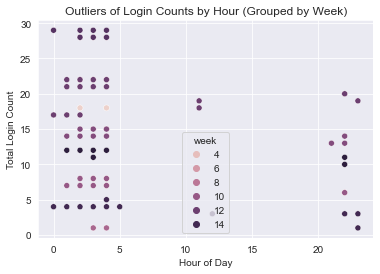

In [20]:
# Look at where the outliers data points are
upper_qrtile = logins_every_15['count'].mean()+(2.5*logins_every_15['count'].std())
outlier_data = logins_every_15[logins_every_15['count']> upper_qrtile]
g = sns.scatterplot(outlier_data['hour'],outlier_data['day'], hue = outlier_data['week'])
g.set_title("Outliers of Login Counts by Hour (Grouped by Week)")
g.set(xlabel="Hour of Day",ylabel="Total Login Count")
plt.show()

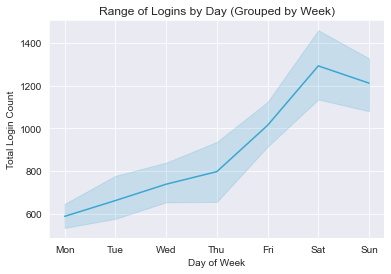

In [21]:
# Look at range of data grouped by day of the week
g1 = sns.lineplot(x=day_grp_logins.index,y=day_grp_logins['count'])
g1.set_xticks(range(7))
g1.set_xticklabels(days)
g1.set_title("Range of Logins by Day (Grouped by Week)")
g1.set(xlabel="Day of Week",ylabel="Total Login Count")
plt.show()

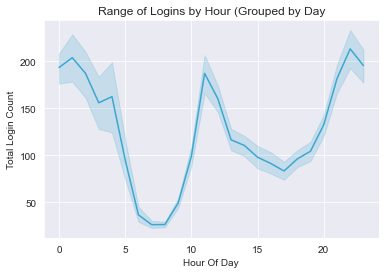

In [22]:
# Look at range of data grouped by the hour for each day of the month
g2 = sns.lineplot(x=hourly_logins.index,y=hourly_logins['count'])
g2.set_title("Range of Logins by Hour (Grouped by Day")
g2.set(xlabel="Hour Of Day",ylabel="Total Login Count")
plt.show()

# Analysis

The data shows that for the 16 weeks monitored, there were a range of logins throughout the day for every day.  

# Demand Cycles
The data indicates that the system has the heaviest volumes outside of typical working hours.  The demand spikes in the evenings and early mornings and at times during lunch.  The trend indicates the highest volume day for logins is Saturday with Sunday the second highest and Monday the lowest.  The highest volume for logins is from hour 22 through hour 2, or 10PM through 2AM.  The demand on Monday through Wednesday is close to half the demand on the weekend.  This is an unbalanced system utilization model.

# Data Quality Issues
The outliers in the dataset are evenly distributed during the peak usage times of 10PM to 2AM.  The data could indicate that high volume use of the system impacted logins during these time periods.  There could be concerns with support and coverage of issues outside of normal working schedule of 8to5 on Monday-Friday.  Highest use volumes are outside of this window and outlier data also appears outside of these times.  It is not clear if the system volume of use impacts logins due to the alignment if issues with volume or if a lack of technical support could impact users during these times.

## Part 2 ‐ Experiment and metrics design

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities.
However, a toll bridge, with a two­way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.

1. Choose the key measure of success of this experiment to encourage driver partners to serve both cities. Why would you choose this metric?

2. Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. 
 
    a. Implement the experiment?
    
    b. Apply statistical test(s) to verify the significance of the observation?
    
    c. Interpret results and make recommendations?


# P2: Key measure of success
The problem statement could propose that the volume of **driver demand** is met for both Gotham and Metropolis for all hours of the day.  The key measures are to monitor the driver demand in both Gotham and Metropolis and to monitor **utilization** in each city.  The drivers should be labeled as their source location being one of the two cities.  

1)**driver demand** (when a need exists for a driver)
2)**utilization** (the number of successful driver events that occurred)

The driver demand compared to driver event indicates if demand is met.  It is important to see where the demand is (source may differ by city) and if the local city supply meets the demand.  If there is an imbalance, success is based on demand being met by utilization, and then to understand from which city the utilization is achieved

# P2: The experiment
The experiment is to monitor for driver demand and utilization values for two weeks to capture all cyclical patterns.  Then the toll reimbursement trial period should be tried for the next two weeks.  The experiment should have a week between to ensure communications exist to all drivers that they know the reimbursements are in place.

**The utilization null hypothesis:**
The utilization for either city does not change when the tolls are reimbursed.  The data between these times should be compared to see if the utilization changed from the time the tolls were in place to a time where they were reimbursed. This data should be monitored for each city to see the differences uniquely.

**The demand null hypothesis**
The demand for either city does not change when the tolls are reimbursed.  The data between these times should be compared to see if the demand changed from the time the tolls were in place to a time where they were reimbursed.  It is not expected that the demand would change, but since there is a change in the process this should be viewed separately from utiliztion

## Part 3 ‐ Predictive modeling

Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in
January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days.
Use the data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate.

The data is in the file ultimate_data_challenge.json. 
Data description

● city: city this user signed up in

● phone: primary device for this user

● signup_date: date of account registration; in the form ‘YYYYMMDD’

● last_trip_date: the last time this user completed a trip; in the form ‘YYYYMMDD’

● avg_dist: the average distance in miles per trip taken in the first 30 days after signup

● avg_rating_by_driver: the rider’s average rating over all of their trips

● avg_rating_of_driver: the rider’s average rating of their drivers over all of their trips

● surge_pct: the percent of trips taken with surge multiplier > 1

● avg_surge: The average surge multiplier over all of this user’s trips

● trips_in_first_30_days: the number of trips this user took in the first 30 days after
signing up

● ultimate_black_user: TRUE if the user took an Ultimate Black in their first 30 days;
FALSE otherwise

● weekday_pct: the percent of the user’s trips occurring during a weekday



1. Perform cleaning, exploratory analysis, and/or visualizations on the provided data for this analysis. Describe fraction of the observed users were retained.

2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.

3. Briefly discuss how Ultimate might leverage the insights gained from the model to improve its long­term rider retention (again, a few sentences will suffice).


## 3b. Load the data

In [23]:
# Read in file
ultimate_challenge = pd.read_json("data/ultimate_data_challenge.json")
print("Shape of dataframe: ",ultimate_challenge.shape)
print("Column Names: \n",ultimate_challenge.columns)
ultimate_challenge.head()

Shape of dataframe:  (50000, 12)
Column Names: 
 Index(['city', 'trips_in_first_30_days', 'signup_date', 'avg_rating_of_driver',
       'avg_surge', 'last_trip_date', 'phone', 'surge_pct',
       'ultimate_black_user', 'weekday_pct', 'avg_dist',
       'avg_rating_by_driver'],
      dtype='object')


,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


### 3c. Explore the data
The dataframe for the date starts with 50000 rows of data and 12 columns.

In [24]:
ultimate_challenge.dtypes

city                       object
trips_in_first_30_days      int64
signup_date                object
avg_rating_of_driver      float64
avg_surge                 float64
last_trip_date             object
phone                      object
surge_pct                 float64
ultimate_black_user          bool
weekday_pct               float64
avg_dist                  float64
avg_rating_by_driver      float64
dtype: object

In [25]:
# The data has 12 columns with 4 objects to be handled
ultimate_challenge.describe

<bound method NDFrame.describe of                  city  trips_in_first_30_days signup_date  \
0      King's Landing                       4  2014-01-25   
1             Astapor                       0  2014-01-29   
2             Astapor                       3  2014-01-06   
3      King's Landing                       9  2014-01-10   
4          Winterfell                      14  2014-01-27   
...               ...                     ...         ...   
49995  King's Landing                       0  2014-01-25   
49996         Astapor                       1  2014-01-24   
49997      Winterfell                       0  2014-01-31   
49998         Astapor                       2  2014-01-14   
49999         Astapor                       0  2014-01-18   

       avg_rating_of_driver  avg_surge last_trip_date    phone  surge_pct  \
0                       4.7       1.10     2014-06-17   iPhone       15.4   
1                       5.0       1.00     2014-05-05  Android        0.0   
2 

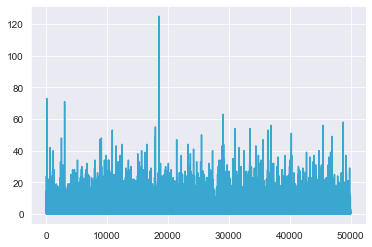

In [54]:
# Data Over Time
plt.plot(ultimate_challenge['trips_in_first_30_days'])
plt.title=('Trips in First 30 Days')
plt.show()

/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


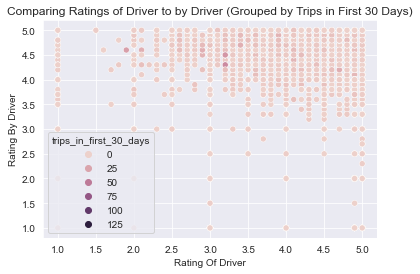

In [57]:
# Compare driver ratings by and for
g = sns.scatterplot(ultimate_challenge['avg_rating_of_driver'],
                    ultimate_challenge['avg_rating_by_driver'], 
                    hue = ultimate_challenge['trips_in_first_30_days'])
g.set_title("Comparing Ratings of Driver to by Driver (Grouped by Trips in First 30 Days)")
g.set(xlabel="Rating Of Driver",ylabel="Rating By Driver")
plt.show()

## 3d. Cleaning, transforming and visualizing

## Missing Value Resolution

In [26]:
# Look for missing values
print('na values',ultimate_challenge.isna().sum(),'\n')

na values city                         0
trips_in_first_30_days       0
signup_date                  0
avg_rating_of_driver      8122
avg_surge                    0
last_trip_date               0
phone                      396
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
avg_dist                     0
avg_rating_by_driver       201
dtype: int64 



values for average rating of driver  [4.7 5.  4.3 4.6 4.4 3.5 nan 4.5 4.  3.9 4.9 4.8 2.5 3.7 1.  4.1 4.2 3.
 3.8 2.  2.7 3.3 2.8 3.6 3.4 3.2 2.6 3.1 2.9 1.7 1.8 1.5 2.3 1.9 2.1 2.4
 1.6 2.2]
mean of values 4.6015592912744685
median of values 4.9


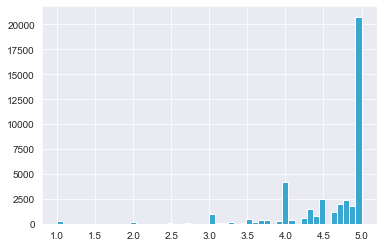

In [27]:
# Look at range of values for 'avg_rating_of_driver' since so many are missing
print("values for average rating of driver ",ultimate_challenge['avg_rating_of_driver'].unique())
print('mean of values',ultimate_challenge['avg_rating_of_driver'].mean())
print('median of values',ultimate_challenge['avg_rating_of_driver'].median())
# look at distribution of values for 'avg_rating_of_driver'
ultimate_challenge['avg_rating_of_driver'].hist(bins=50)
plt.show()

values for average rating of driver  [4.7 5.  4.3 4.6 4.4 3.5 4.9 4.5 4.  3.9 4.8 2.5 3.7 1.  4.1 4.2 3.  3.8
 2.  2.7 3.3 2.8 3.6 3.4 3.2 2.6 3.1 2.9 1.7 1.8 1.5 2.3 1.9 2.1 2.4 1.6
 2.2]


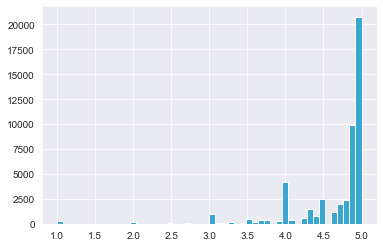

In [28]:
# since data is not normal, fill missing ratings with median value
median_val = ultimate_challenge['avg_rating_of_driver'].median()
ultimate_challenge['avg_rating_of_driver'].fillna(median_val, inplace=True)
print("values for average rating of driver ",ultimate_challenge['avg_rating_of_driver'].unique())
# look at distribution of values for 'avg_rating_of_driver'
ultimate_challenge['avg_rating_of_driver'].hist(bins=50)
plt.show()

values for average rating of driver  [5.  4.9 4.  3.  4.8 4.7 4.5 4.2 nan 4.4 4.6 3.7 4.3 3.5 2.  3.8 2.5 4.1
 3.9 1.  3.3 3.4 3.6 3.2 2.3 2.8 1.5 2.7]
mean of values 4.778158195947439
median of values 5.0


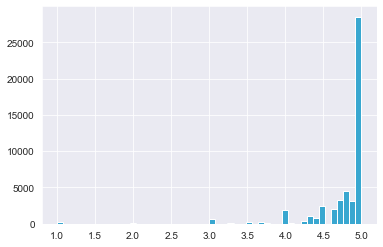

In [29]:
# Look at range of values for 'avg_rating_by_driver' since so many are missing
print("values for average rating of driver ",ultimate_challenge['avg_rating_by_driver'].unique())
print('mean of values',ultimate_challenge['avg_rating_by_driver'].mean())
print('median of values',ultimate_challenge['avg_rating_by_driver'].median())
# look at distribution of values for 'avg_rating_of_driver'
ultimate_challenge['avg_rating_by_driver'].hist(bins=50)
plt.show()

values for average rating of driver  [5.  4.9 4.  3.  4.8 4.7 4.5 4.2 4.4 4.6 3.7 4.3 3.5 2.  3.8 2.5 4.1 3.9
 1.  3.3 3.4 3.6 3.2 2.3 2.8 1.5 2.7]


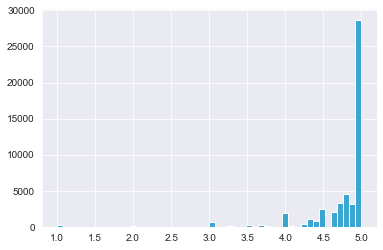

In [30]:
# data is not normal, but median is top of range.  fill missing ratings with mean value
mean_val = ultimate_challenge['avg_rating_by_driver'].median()
ultimate_challenge['avg_rating_by_driver'].fillna(mean_val, inplace=True)
print("values for average rating of driver ",ultimate_challenge['avg_rating_by_driver'].unique())
# look at distribution of values for 'avg_rating_of_driver'
ultimate_challenge['avg_rating_by_driver'].hist(bins=50)
plt.show()

## Converting String Values

In [31]:
# City column has three different city names
# map these values into the column
city_map = {"King's Landing":1 , "Winterfell":2 , "Astapor":3}
ultimate_challenge['city'] = [city_map[item] for item in ultimate_challenge['city']]
# Display resultant categorization in 'city' column
ultimate_challenge['city'].value_counts()

2    23336
3    16534
1    10130
Name: city, dtype: int64

In [32]:
# Phone column has two different answers, but multiple nulls
# Replace nulls with 0
ultimate_challenge['phone'].fillna("Empty",inplace=True)
# map values for 'iPhone' and 'Android'
phone_map = {"iPhone":1 , "Android":2, "Empty":0}
ultimate_challenge['phone'] = [phone_map[item] for item in ultimate_challenge['phone']]
# Display resultant categorization in 'phone' column
ultimate_challenge['phone'].value_counts()

1    34582
2    15022
0      396
Name: phone, dtype: int64

## Set Dates from String values

In [33]:
# 'signup_date' Date field to be set as datetime
ultimate_challenge['signup_date'] = pd.to_datetime(ultimate_challenge['signup_date'])
ultimate_challenge['signup_date'].describe()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  This is separate from the ipykernel package so we can avoid doing imports until


count                   50000
unique                     31
top       2014-01-18 00:00:00
freq                     2948
first     2014-01-01 00:00:00
last      2014-01-31 00:00:00
Name: signup_date, dtype: object

In [34]:
# 'last_trip_date' Date field to be set as datetime
ultimate_challenge['last_trip_date'] = pd.to_datetime(ultimate_challenge['last_trip_date'])
ultimate_challenge['last_trip_date'].describe()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  This is separate from the ipykernel package so we can avoid doing imports until


count                   50000
unique                    182
top       2014-06-29 00:00:00
freq                     2036
first     2014-01-01 00:00:00
last      2014-07-01 00:00:00
Name: last_trip_date, dtype: object

In [35]:
# Create new feature column of time between signup_date and last_trip_date
ultimate_challenge['days_since_signup'] = (ultimate_challenge['last_trip_date']- ultimate_challenge['signup_date']).dt.days
ultimate_challenge['days_since_signup'].value_counts()

1      4374
0      2302
2      1063
155     756
154     687
       ... 
24      104
60      103
38       92
180      72
181      13
Name: days_since_signup, Length: 182, dtype: int64

In [36]:
# Verify all fields coverted from object to values, no strings remain
ultimate_challenge.dtypes

city                               int64
trips_in_first_30_days             int64
signup_date               datetime64[ns]
avg_rating_of_driver             float64
avg_surge                        float64
last_trip_date            datetime64[ns]
phone                              int64
surge_pct                        float64
ultimate_black_user                 bool
weekday_pct                      float64
avg_dist                         float64
avg_rating_by_driver             float64
days_since_signup                  int64
dtype: object

## Initial look at variable relationships

<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


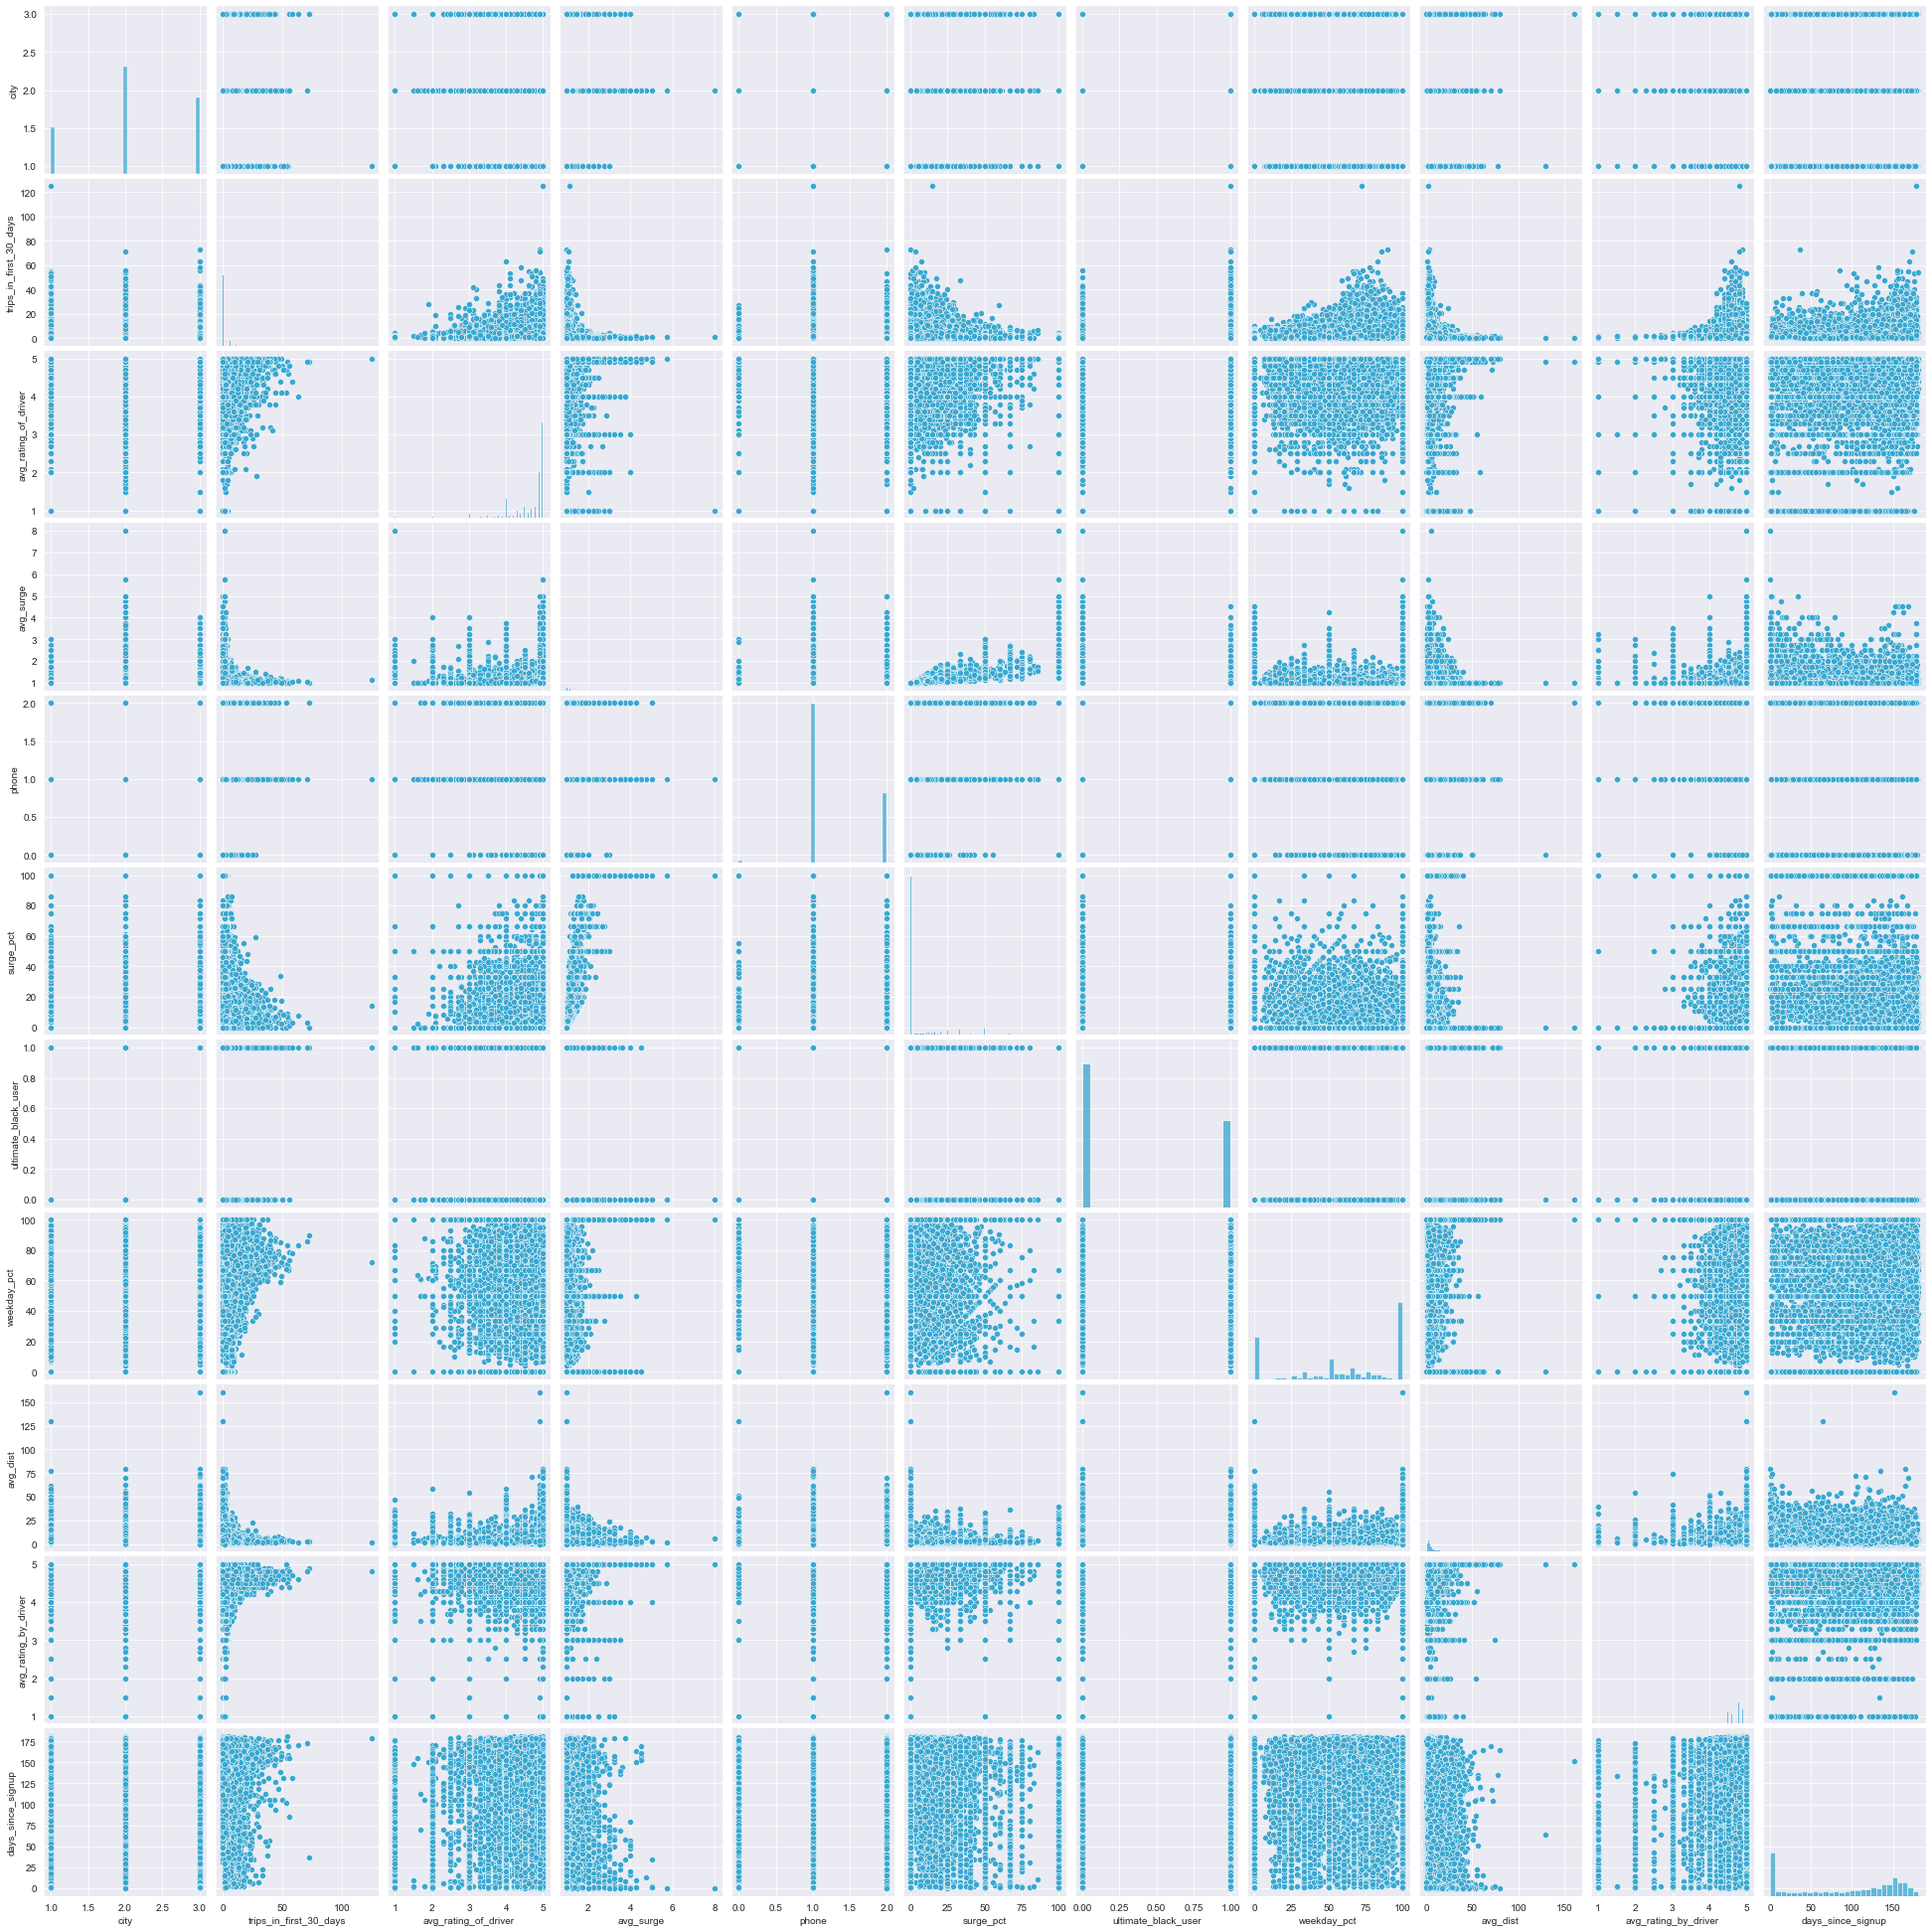

In [37]:
sns.pairplot(ultimate_challenge)
plt.show()

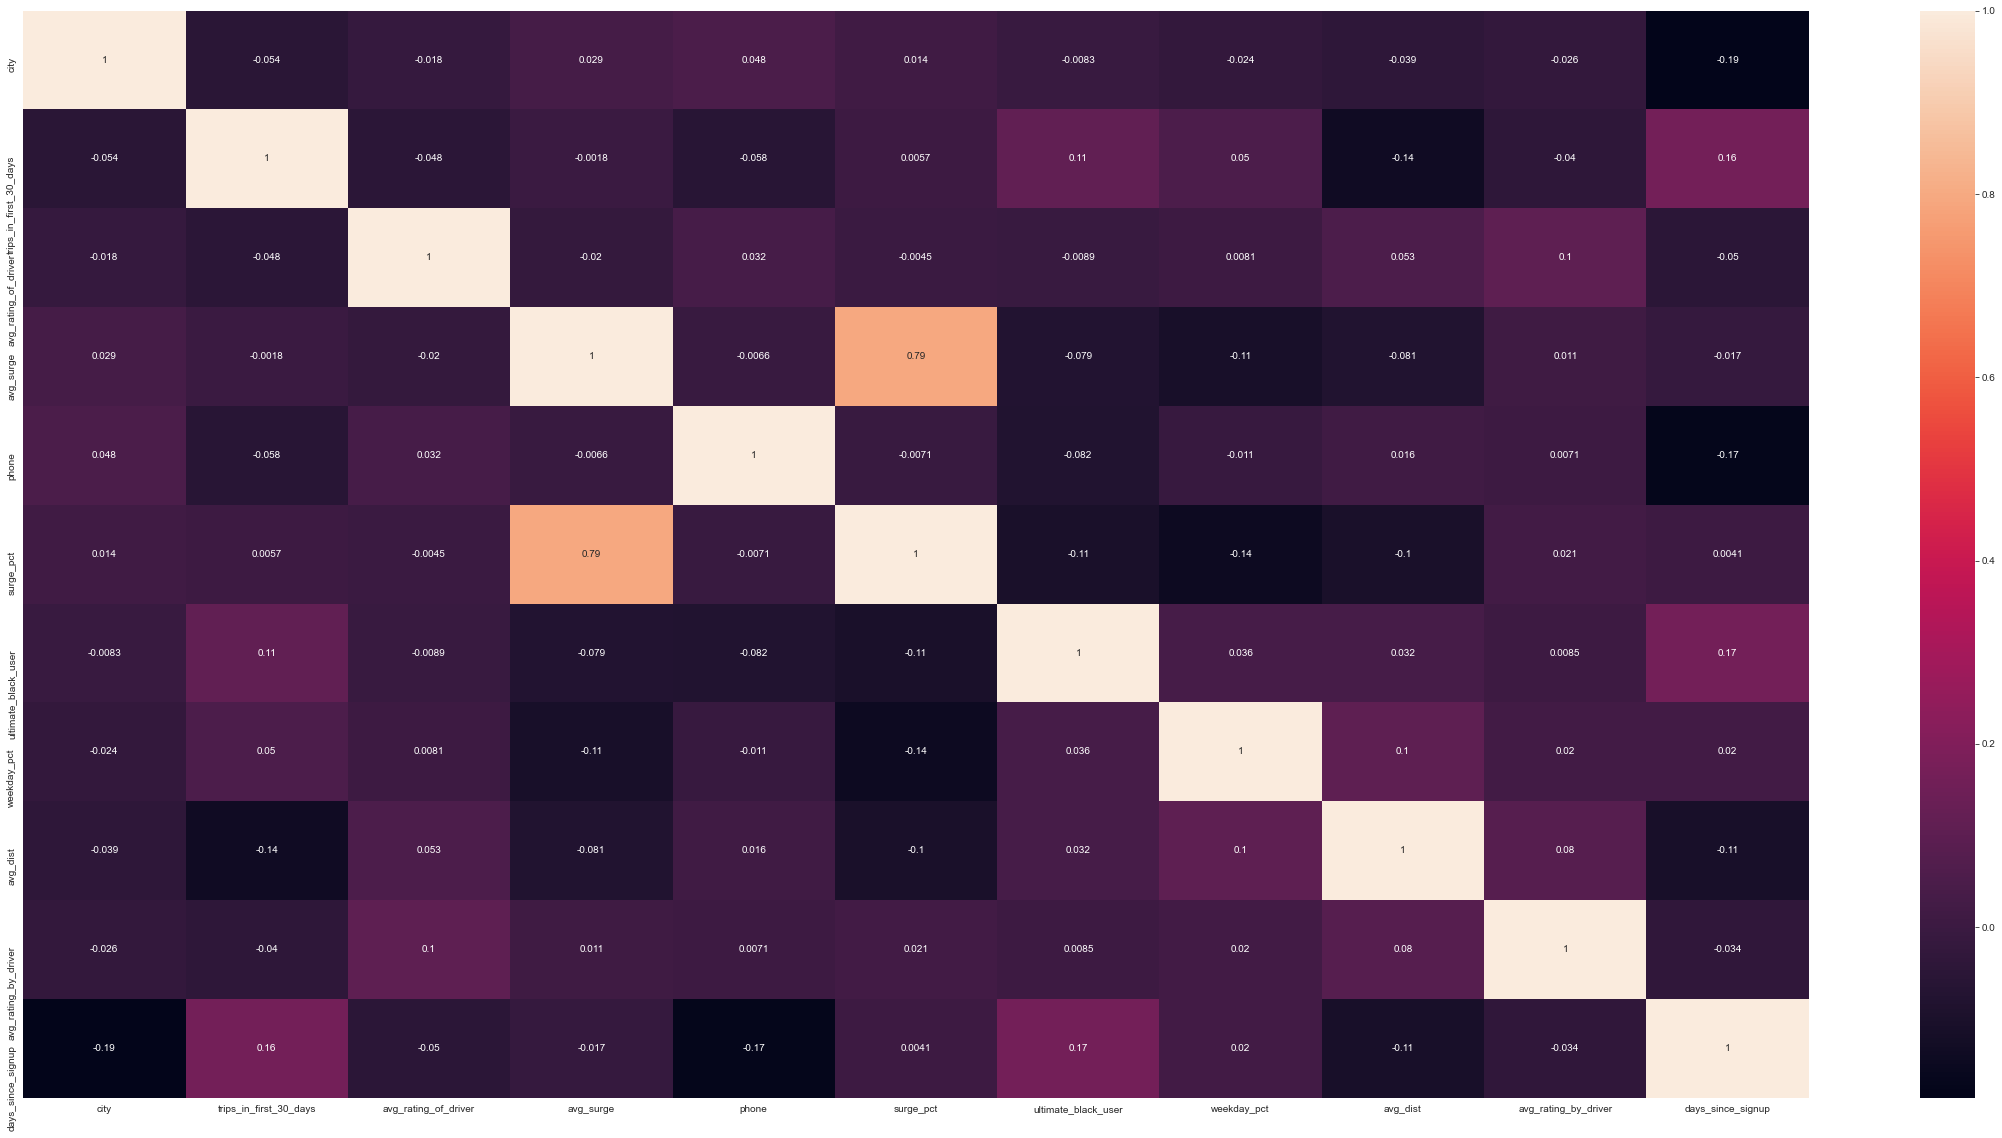

In [38]:
plt.figure(figsize=(40,20))

# Make a heatmap of the data 
# Ensure to plug in, as first parameter, wine.corr(), and as second parameter, annot=True (so the graph is annotated)
sns.heatmap(ultimate_challenge.corr(), annot=True)
plt.show()

## 3e. Defining OUTPUT variable to indicate retention
Retention is defined as rider who rode within 30 days after signup.  
Base this 'retention' Feature on the 'trips_in_first_30_days' feature being above 0

In [39]:
ultimate_challenge['retention'] = np.where(ultimate_challenge['trips_in_first_30_days'] > 0,1,0)
print("Retention distribution",ultimate_challenge['retention'].describe(),'\n')
print("Percentage of Retained Drivers at Start: ",
      ultimate_challenge['retention'].sum()/ultimate_challenge['retention'].count())

Retention distribution count    50000.000000
mean         0.692200
std          0.461588
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: retention, dtype: float64 

Percentage of Retained Drivers at Start:  0.6922


## Sect 3: Q1:  69.22% of Riders retained in first 30 days
Based on sum of trips_in_first_30_days > 0 diveded by total count of observances

In [40]:
# List all column names for determination of inputs to model
ultimate_challenge.columns

Index(['city', 'trips_in_first_30_days', 'signup_date', 'avg_rating_of_driver',
       'avg_surge', 'last_trip_date', 'phone', 'surge_pct',
       'ultimate_black_user', 'weekday_pct', 'avg_dist',
       'avg_rating_by_driver', 'days_since_signup', 'retention'],
      dtype='object')

## Sect 3: Q2:  Build a Predictive Model
This will be a logistic Regression model with output target retention

In [41]:
# To determine a prediction model for Rider Retention, a Logistic Regression model 
# will be applied initially using all input columns except the target of 'retention'
X = ultimate_challenge[['city','avg_rating_of_driver','avg_surge','phone','surge_pct','ultimate_black_user','weekday_pct', 'avg_dist', 'avg_rating_by_driver','days_since_signup']]
# target is 'retention' for predicting a categorical result
y = ultimate_challenge['retention']
model = LogisticRegression(max_iter=200)

In [42]:
## Split data for model Train, Test
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state = 64)
# Standardize the data for model accuracy and convergence
pipe = make_pipeline(StandardScaler(), LogisticRegression())
pipe.fit(X_train, y_train)  # apply scaling on training data
model.fit(X_train,y_train)
accuracy= pipe.score(X_test, y_test)  # apply scaling on testing data, without leaking training data
#accuracy = accuracy_score(model.predict(X_test), y_test)
print("Accuracy Score: ",accuracy)
print("Coefficients: \n",model.coef_)

Accuracy Score:  0.6887
Coefficients: 
 [[-9.82002256e-02 -1.95735624e-01  1.06559660e+00 -1.52228757e-01
  -6.21496753e-03  3.91773257e-01  9.93343537e-04 -3.65815523e-02
   8.41125758e-02 -9.02478492e-03]]


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


# Visualize Results

In [46]:
# import the metrics class
from sklearn import metrics

y_pred=model.predict(X_test)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[ 209, 2921],
       [ 176, 6694]])

Text(0.5, 257.44, 'Predicted label')

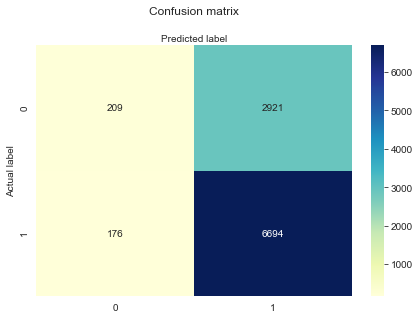

In [47]:
# Show Heatmap
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [48]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.6903
Precision: 0.6962038481539261
Recall: 0.9743813682678312


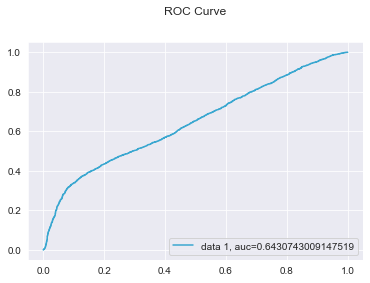

In [51]:
# ROC Curve
y_pred_proba = model.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.title('ROC Curve', y=1.1)
plt.show()

In [58]:
# Accuracy rate too low on intial inspection.  Look at further variable interactions for better model
